In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.metrics import make_scorer, mean_squared_error

In [3]:
#load dataset
with open('./zhengqi_train.txt') as fr:
    train_data = pd.read_csv(fr, sep='\t')
with open('./zhengqi_test.txt') as fr_test:
    test_data = pd.read_csv(fr_test, sep='\t')

In [4]:
# merge train set and test set
train_data["origin"] = "train"
test_data["origin"] = "test"
# 在数据中加入origin字段
all_data = pd.concat([train_data, test_data], sort=True, ignore_index=True)
# view data
all_data.head()
# test data的target字段为空

V0     V1    V10    V11    V12    V13    V14    V15    V16    V17  ...  \
0  0.566  0.016 -0.940 -0.307 -0.073  0.550 -0.484  0.000 -1.707 -1.162  ...   
1  0.968  0.437  0.188 -0.455 -0.134  1.109 -0.488  0.000 -0.977 -1.162  ...   
2  1.013  0.568  0.874 -0.051 -0.072  0.767 -0.493 -0.212 -0.618 -0.897  ...   
3  0.733  0.368  0.011  0.102 -0.014  0.769 -0.371 -0.162 -0.429 -0.897  ...   
4  0.684  0.638 -0.251  0.570  0.199 -0.349 -0.342 -0.138 -0.391 -0.897  ...   

     V36    V37     V4     V5     V6     V7     V8     V9  origin  target  
0 -2.608 -3.508  0.452 -0.901 -1.812 -2.360 -0.436 -2.114   train   0.175  
1 -0.335 -0.730  0.194 -0.893 -1.566 -2.360  0.332 -2.114   train   0.676  
2  0.765 -0.589  0.112 -0.797 -1.367 -2.360  0.396 -2.114   train   0.633  
3  0.333 -0.112  0.599 -0.679 -1.200 -2.086  0.403 -2.114   train   0.206  
4 -0.280 -0.028  0.337 -0.454 -1.073 -2.086  0.314 -2.114   train   0.384  

[5 rows x 40 columns]

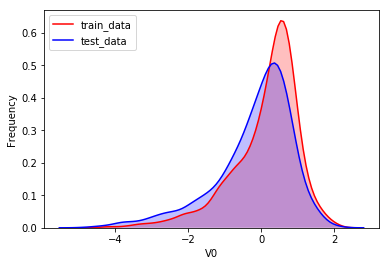

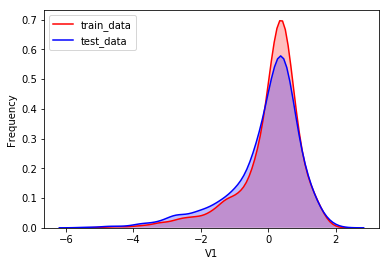

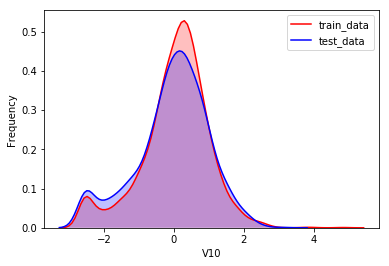

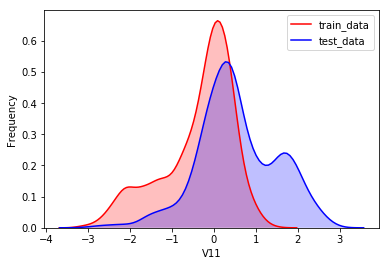

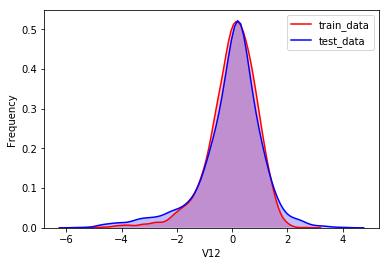

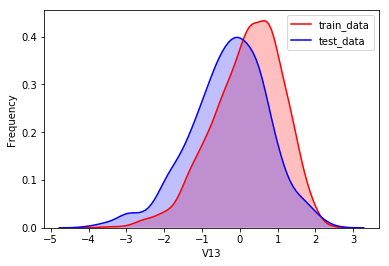

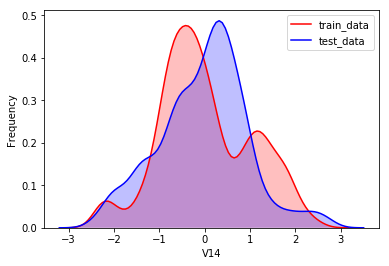

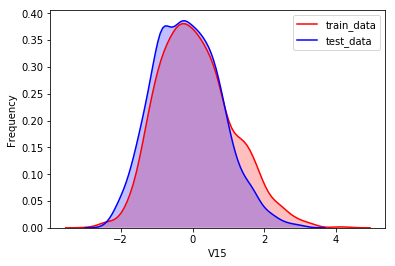

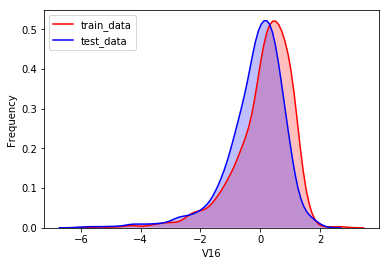

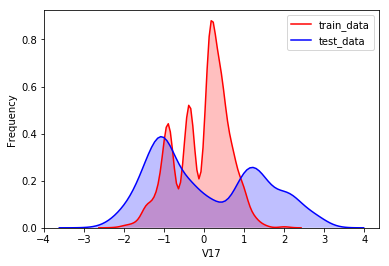

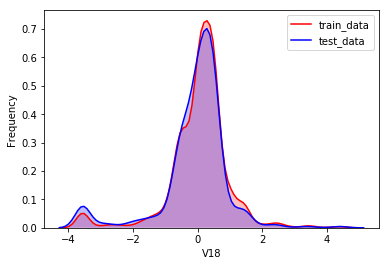

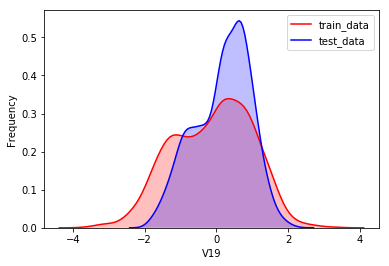

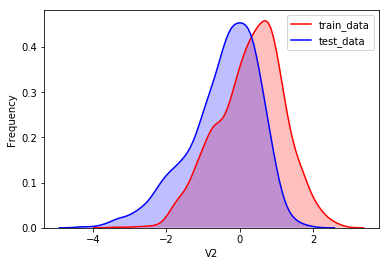

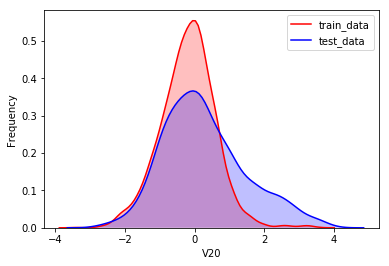

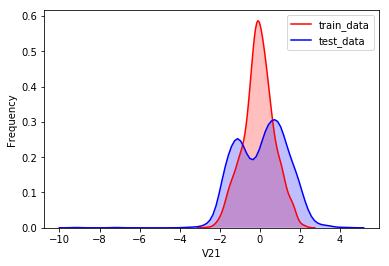

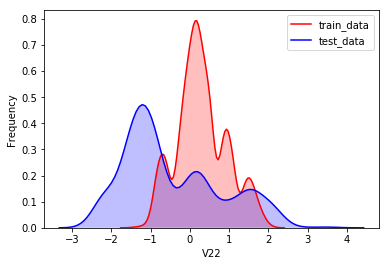

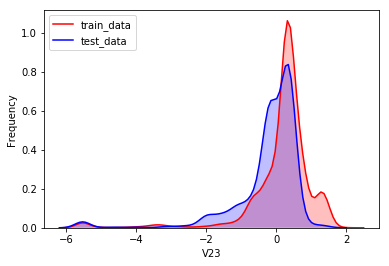

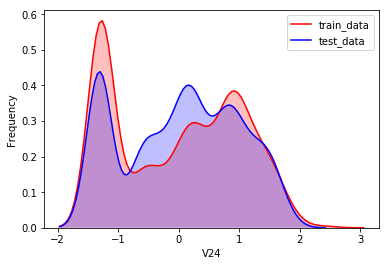

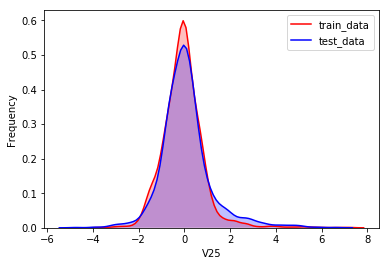

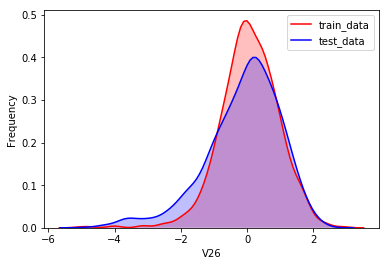

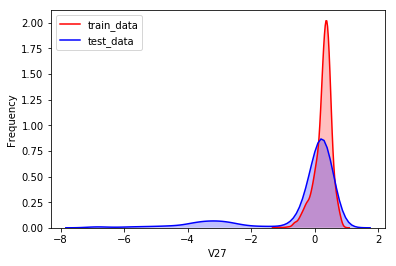

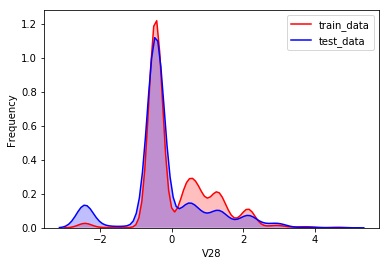

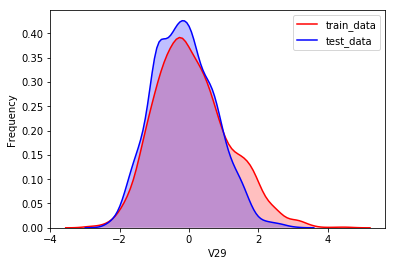

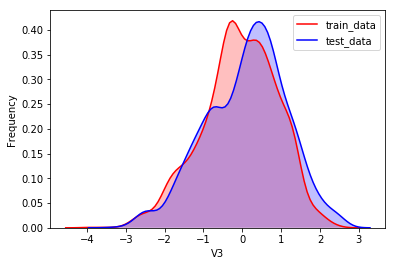

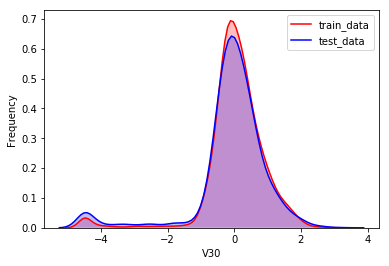

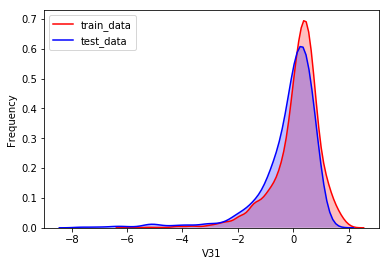

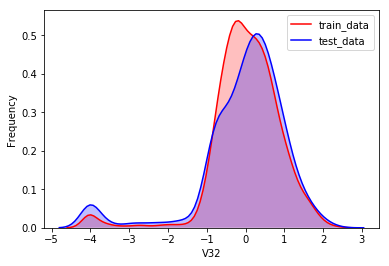

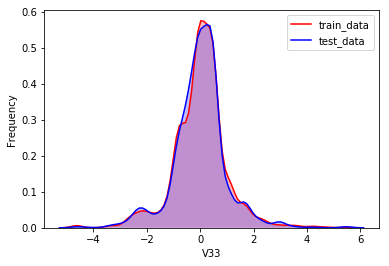

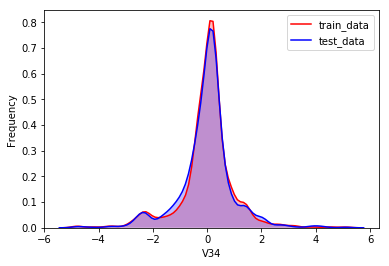

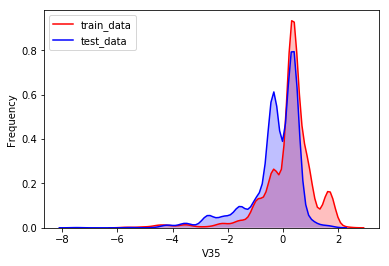

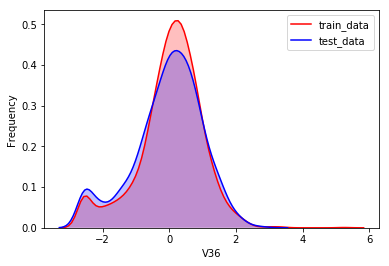

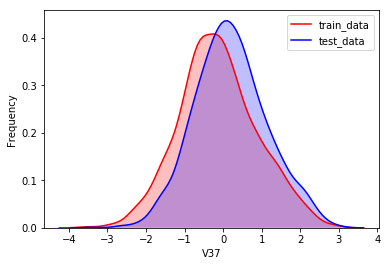

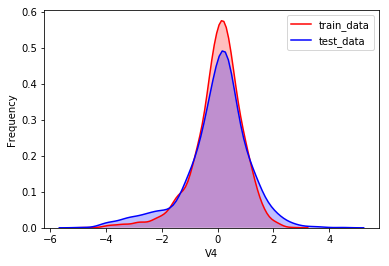

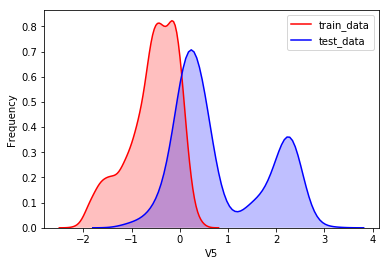

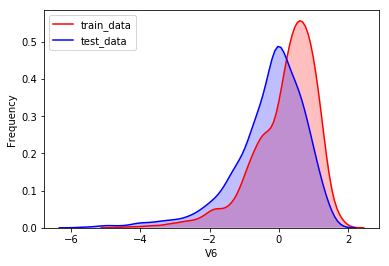

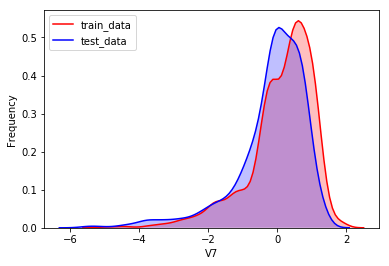

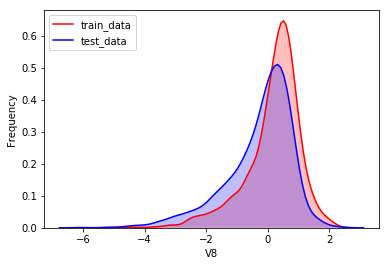

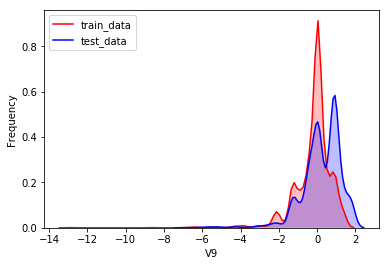

In [5]:
# explore feature distribution
for column in all_data.columns[0: -2]:   # 不考虑origin和target
    # column=V0, V1, V2...V37
    g = sns.kdeplot(all_data[column][(all_data["origin"] == "train")], color="Red", shade=True)
    g = sns.kdeplot(all_data[column][(all_data["origin"] == "test")], color="Blue", shade=True)
    g.set_xlabel(column)
    g.set_ylabel("Frequency")
    g = g.legend(["train_data", "test_data"])
    plt.show()
    # sns.kdeplot 核密度估计图可以比较直观的看出数据样本本身的分布特征
    # kde = kernel density estimate

In [6]:
# 手动选取测试集合训练集分布不符的特征
# 删除V9, V5, V22, V17, V11这几个特征
all_data.drop(["V5", "V9", "V11", "V17", "V22"], axis=1, inplace=True)
# 二维数据有两个轴： 0轴沿着行的垂直往下， 1轴沿着列的水平方向延伸
# inplace=True return None

In [7]:
all_data.head()

V0     V1    V10    V12    V13    V14    V15    V16    V18    V19  ...  \
0  0.566  0.016 -0.940 -0.073  0.550 -0.484  0.000 -1.707 -0.573 -0.991  ...   
1  0.968  0.437  0.188 -0.134  1.109 -0.488  0.000 -0.977 -0.571 -0.836  ...   
2  1.013  0.568  0.874 -0.072  0.767 -0.493 -0.212 -0.618 -0.564 -0.558  ...   
3  0.733  0.368  0.011 -0.014  0.769 -0.371 -0.162 -0.429 -0.574 -0.564  ...   
4  0.684  0.638 -0.251  0.199 -0.349 -0.342 -0.138 -0.391 -0.572 -0.394  ...   

     V34    V35    V36    V37     V4     V6     V7     V8  origin  target  
0 -4.789 -5.101 -2.608 -3.508  0.452 -1.812 -2.360 -0.436   train   0.175  
1  0.160  0.364 -0.335 -0.730  0.194 -1.566 -2.360  0.332   train   0.676  
2  0.160  0.364  0.765 -0.589  0.112 -1.367 -2.360  0.396   train   0.633  
3 -0.065  0.364  0.333 -0.112  0.599 -1.200 -2.086  0.403   train   0.206  
4 -0.215  0.364 -0.280 -0.028  0.337 -1.073 -2.086  0.314   train   0.384  

[5 rows x 35 columns]

In [8]:
type(all_data)

pandas.core.frame.DataFrame

In [9]:
new_train_data = all_data[all_data["origin"] == "train"].drop("origin", axis=1)
new_test_data = all_data[all_data["origin"] == "test"].drop(["origin", "target"], axis=1)
# 去除分布不同的特征后再根据origin分离train data和test data

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


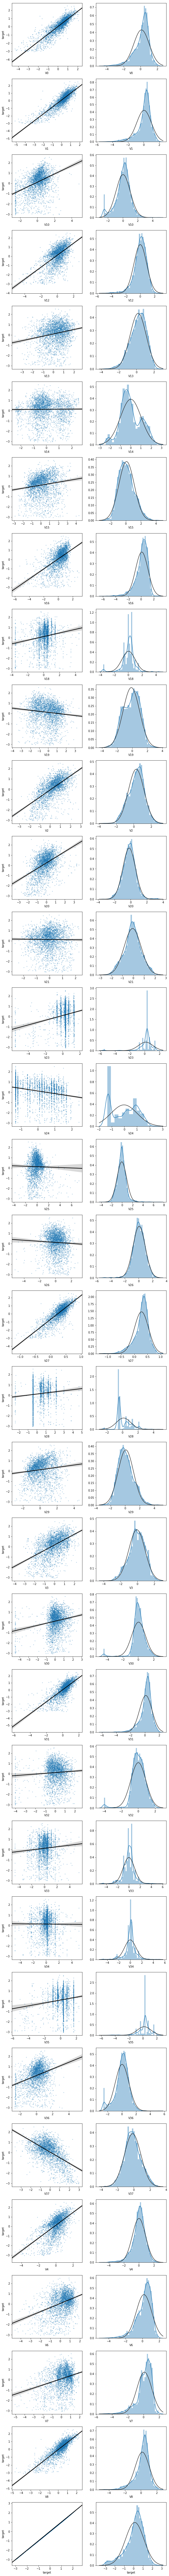

In [10]:
rows = len(new_train_data.columns)
fig = plt.figure(figsize=(10, 5 * rows))

i = 0
for col in new_train_data.columns:
    i += 1
    ax = plt.subplot(rows, 2, i)
    sns.regplot(x=col, y="target", data=new_train_data, ax=ax, 
                scatter_kws={"marker": ".", "s": 3, "alpha": 0.3},
                line_kws={"color": "k"})
    plt.xlabel(col)
    plt.ylabel("target")
    # sns.regplot(x, y, data=None, scatter_kws=None, line_kws=None, logistic=False)
    # x, y: Input variables. If strings, these should correspond with column names in data
    # data: DataFrame
    # logistic: Bool. If True, assume y is a binary variable and use logistic regression model
    
    i += 1
    ax = plt.subplot(rows, 2, i)
    sns.distplot(new_train_data[col].dropna(), fit=stats.norm)
    plt.xlabel(col)
    # sns.distplot(a, bins=None, kde=True, fit=None)
    # kde: Bool. Whether to plot a gaussian kernel density estimate 

In [11]:
# 找出相关程度
colmn = new_train_data.columns.tolist()
mcorr = new_train_data[colmn].corr(method="spearman")

In [12]:
mcorr

V0        V1       V10       V12       V13       V14       V15  \
V0      1.000000  0.894256  0.278814  0.639393  0.173603 -0.002387  0.333447   
V1      0.894256  1.000000  0.255167  0.594844  0.134310  0.003181  0.229663   
V10     0.278814  0.255167  1.000000  0.108929 -0.099163 -0.109131 -0.013153   
V12     0.639393  0.594844  0.108929  1.000000  0.101443  0.034077  0.702702   
V13     0.173603  0.134310 -0.099163  0.101443  1.000000  0.566872  0.048716   
V14    -0.002387  0.003181 -0.109131  0.034077  0.566872  1.000000  0.045037   
V15     0.333447  0.229663 -0.013153  0.702702  0.048716  0.045037  1.000000   
V16     0.388675  0.395934  0.473350 -0.025110  0.074832 -0.007471 -0.280254   
V18     0.133431  0.095113  0.038124  0.124790  0.241614  0.106115  0.108519   
V19    -0.143592 -0.145803  0.089112 -0.174409 -0.105909  0.049240 -0.215258   
V2      0.517319  0.490908  0.292613  0.054992  0.180415 -0.081980 -0.206482   
V20     0.445772  0.422927  0.226341  0.221167  0.004569 -0.146338  0.050448   
V21    -0.007521  0.045884  0.063436  0.179757 -0.475270 -0.160156  0.136685   
V23     0.056849  0.040673 -0.102651  0.122004  0.172756  0.246251  0.182529   
V24    -0.335252 -0.288625 -0.033806 -0.591039 -0.073712 -0.024463 -0.686946   
V25    -0.045263  0.011126  0.174860 -0.414229 -0.082804 -0.182097 -0.623524   
V26    -0.138330 -0.055103  0.029228 -0.139226  0.016159 -0.019519 -0.164393   
V27     0.763410  0.807414  0.202614  0.335152  0.126618 -0.004546  0.006690   
V28     0.037108  0.058393  0.066985 -0.130851  0.017414 -0.115438 -0.232129   
V29     0.333527  0.239829 -0.059274  0.731735  0.025279  0.033863  0.947348   
V3      0.399921  0.362483  0.295140  0.286590 -0.019189 -0.229566  0.145613   
V30     0.100600  0.110668  0.027177 -0.055326 -0.097034 -0.026926 -0.147673   
V31     0.738433  0.806790  0.445196  0.471155  0.071742  0.003248  0.110939   
V32    -0.050431 -0.014485 -0.075175 -0.074621  0.082271  0.131324 -0.114684   
V33     0.056298  0.023336  0.021731  0.055579  0.194044  0.093640  0.076154   
V34    -0.027432 -0.047713 -0.019655  0.037539  0.163130  0.070706  0.102221   
V35     0.039567  0.034086 -0.060051  0.112444  0.181742  0.264801  0.185105   
V36     0.214309  0.192307  0.892266  0.084581 -0.067293 -0.118745 -0.011781   
V37    -0.473005 -0.398149 -0.025478  0.028968 -0.344138  0.003354  0.234783   
V4      0.696039  0.650196  0.122648  0.897896  0.061020  0.024286  0.640119   
V6      0.132296  0.147891  0.336306 -0.195643  0.089094  0.055128 -0.443087   
V7      0.076254  0.083318  0.242932 -0.157466  0.059921  0.143009 -0.334760   
V8      0.831926  0.848793  0.351478  0.367446  0.105871  0.002166  0.054964   
target  0.866709  0.832457  0.371067  0.542429  0.177317  0.011385  0.213490   

             V16       V18       V19  ...       V33       V34       V35  \
V0      0.388675  0.133431 -0.143592  ...  0.056298 -0.027432  0.039567   
V1      0.395934  0.095113 -0.145803  ...  0.023336 -0.047713  0.034086   
V10     0.473350  0.038124  0.089112  ...  0.021731 -0.019655 -0.060051   
V12    -0.025110  0.124790 -0.174409  ...  0.055579  0.037539  0.112444   
V13     0.074832  0.241614 -0.105909  ...  0.194044  0.163130  0.181742   
V14    -0.007471  0.106115  0.049240  ...  0.093640  0.070706  0.264801   
V15    -0.280254  0.108519 -0.215258  ...  0.076154  0.102221  0.185105   
V16     1.000000  0.066266 -0.019464  ...  0.002156 -0.125740 -0.061985   
V18     0.066266  1.000000 -0.033433  ...  0.665102  0.359373  0.127076   
V19    -0.019464 -0.033433  1.000000  ... -0.035762 -0.088089 -0.322470   
V2      0.783385  0.116077 -0.178758  ...  0.050666 -0.045764 -0.051460   
V20     0.239546  0.052246  0.030162  ...  0.011320 -0.003984 -0.043142   
V21    -0.055939 -0.159010 -0.073264  ... -0.133678 -0.075014 -0.125225   
V23    -0.100430  0.193960 -0.298362  ...  0.143845  0.266307  0.835226   
V24     0.064671 -0.219739  0.287713  ... -0.177825 -0.116003 -0.250573   
V25     0.529

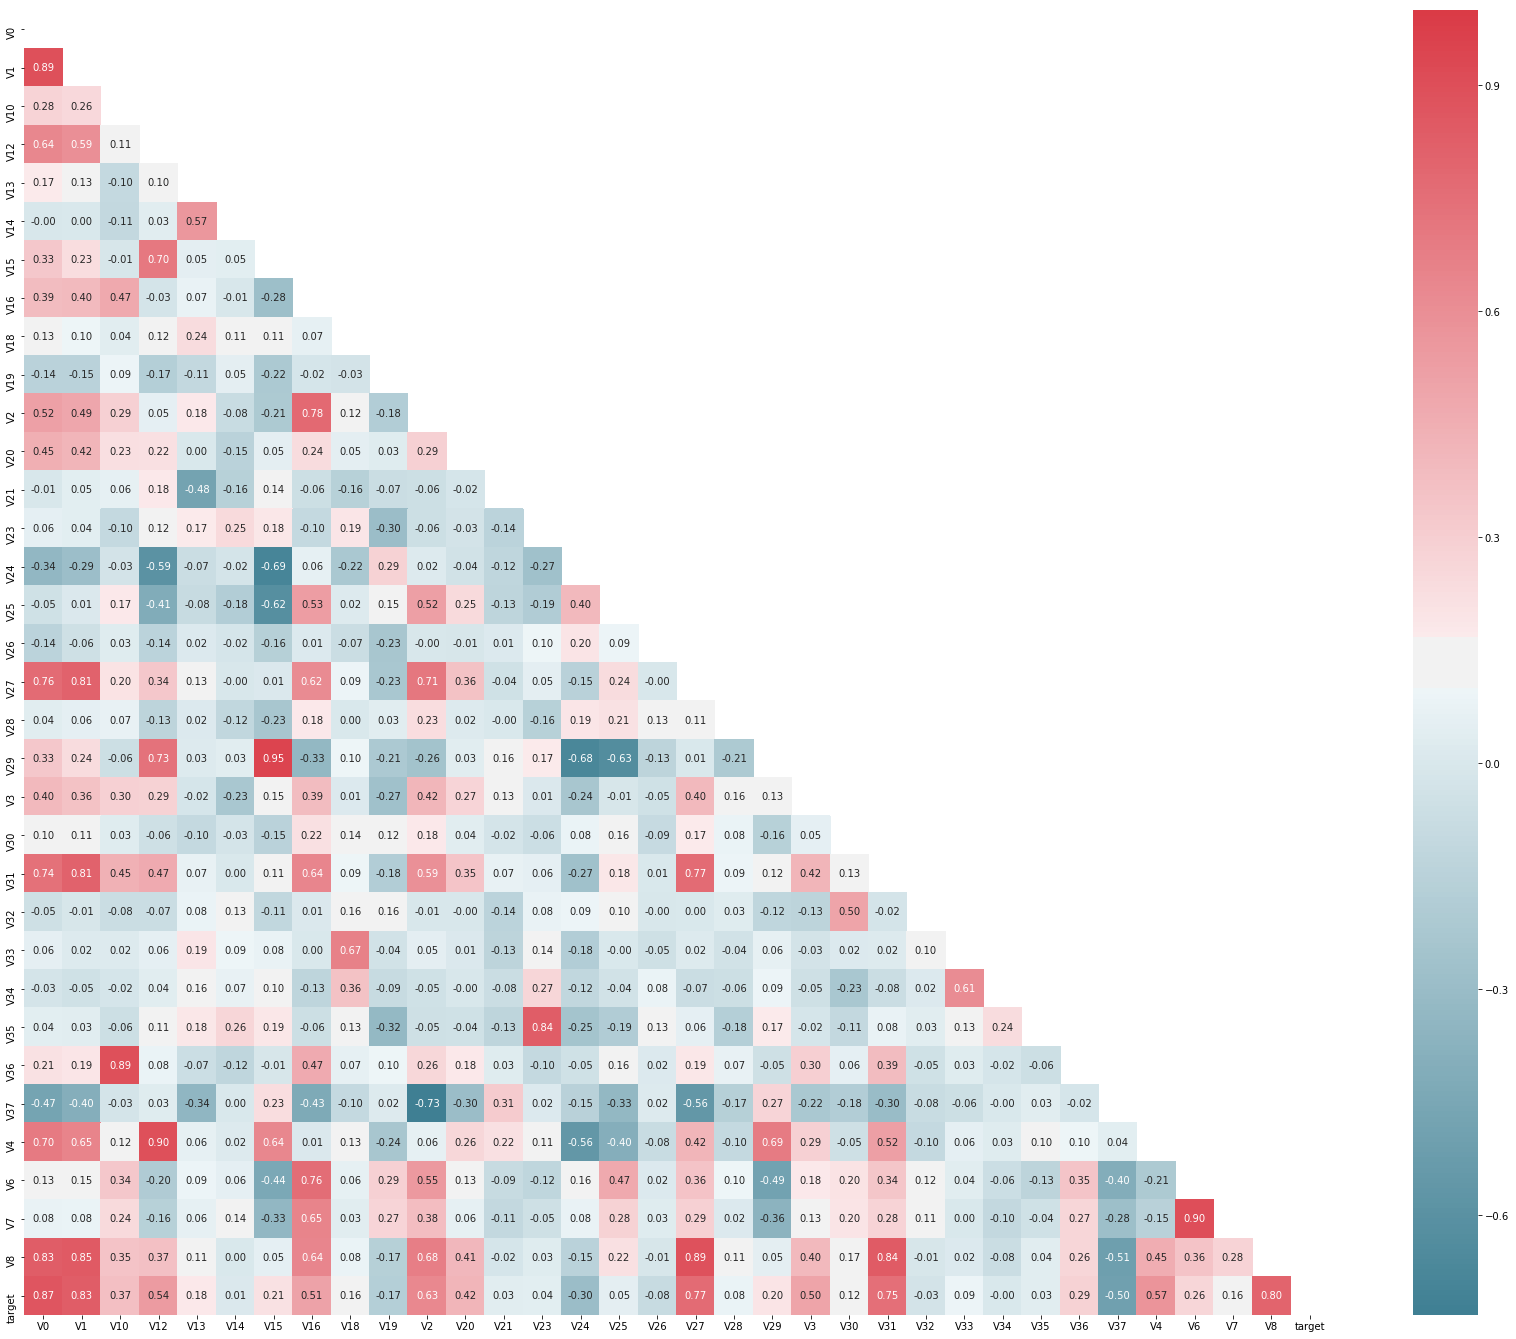

In [13]:
plt.figure(figsize=(30, 24))
mask = np.zeros_like(mcorr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True  # 角分线右侧为True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
g= sns.heatmap(mcorr, mask=mask, cmap=cmap, square=True, annot=True, fmt='0.2f') # 热力图（看两两相似度）
plt.show()

In [14]:
threshold = 0.1

corr_matrix = new_train_data.corr().abs()
drop_col = corr_matrix[corr_matrix["target"]<threshold].index

In [15]:
drop_col

Index(['V14', 'V21', 'V25', 'V26', 'V32', 'V33', 'V34'], dtype='object')

In [30]:
all_data.drop(drop_col, axis=1, inplace=True)

In [31]:
all_data

V0        V1       V10       V12       V13       V15       V16  \
0     0.775775  0.723449  0.221743  0.570828  0.694786  0.402245  0.487950   
1     0.833742  0.778785  0.373887  0.564418  0.778544  0.402245  0.569779   
2     0.840231  0.796004  0.466415  0.570933  0.727300  0.372870  0.610021   
3     0.799856  0.769716  0.350013  0.577028  0.727600  0.379798  0.631207   
4     0.792790  0.805205  0.314675  0.599412  0.560084  0.383123  0.635467   
5     0.758327  0.803759  0.279606  0.609395  0.749026  0.417625  0.641968   
6     0.822350  0.776025  0.314001  0.623161  0.707072  0.417625  0.641968   
7     0.836049  0.790878  0.339493  0.607083  0.729248  0.436054  0.686582   
8     0.830858  0.833070  0.376180  0.619168  0.569224  0.442843  0.697904   
9     0.860995  0.860016  0.368087  0.650799  0.591399  0.446169  0.701155   
10    0.855083  0.867508  0.364985  0.692308  0.676656  0.543162  0.697343   
11    0.851766  0.868559  0.458727  0.733186  0.544951  0.556325  0.710907   
12    0.603028  0.595294  0.351902  0.534468  0.597543  0.622835  0.712140   
13    0.550108  0.544821  0.132317  0.499580  0.697633  0.688236  0.575160   
14    0.660418  0.688749  0.213110  0.614229  0.677705  0.688236  0.558794   
15    0.564672  0.582413  0.314810  0.552543  0.694037  0.676597  0.537944   
16    0.636049  0.657466  0.249798  0.616015  0.569224  0.627546  0.515301   
17    0.527181  0.519190  0.224845  0.516393  0.700779  0.627546  0.487950   
18    0.602163  0.680336  0.211762  0.598361  0.807911  0.502148  0.493218   
19    0.748234  0.776814  0.213650  0.633985  0.780641  0.494388  0.537160   
20    0.724585  0.771951  0.333693  0.626103  0.784237  0.409866  0.558570   
21    0.688248  0.733570  0.376180  0.599622  0.826341  0.367466  0.579868   
22    0.747368  0.784306  0.333153  0.586066  0.795625  0.367466  0.606098   
23    0.673540  0.675999  0.326275  0.574821  0.763560  0.342247  0.620222   
24    0.401730  0.371057  0.554087  0.404372  0.767156  0.358182  0.588275   
25    0.450180  0.434805  0.064203  0.492329  0.700030  0.405847  0.527183   
26    0.783273  0.753549  0.000944  0.600042  0.696284  0.484689  0.525165   
27    0.866619  0.874606  0.127327  0.676019  0.955948  0.484689  0.596234   
28    0.853641  0.876052  0.436741  0.731295  0.833683  0.598725  0.669207   
29    0.760779  0.784437  0.577691  0.651534  0.833983  0.591797  0.671674   
...        ...       ...       ...       ...       ...       ...       ...   
4783  0.746647  0.755258  0.128136  0.616120  0.720258  0.512124  0.563166   
4784  0.661283  0.651157  0.301322  0.593317  0.534912  0.527920  0.592759   
4785  0.537707  0.483964  0.347721  0.501471  0.515433  0.535680  0.528192   
4786  0.716943  0.696767  0.067845  0.595839  0.628858  0.539698  0.522251   
4787  0.646864  0.650105  0.294173  0.585225  0.612227  0.520299  0.554534   
4788  0.623648  0.636041  0.284866  0.592476  0.680551  0.520299  0.541755   
4789  0.675415  0.743691  0.317373  0.651219  0.658076  0.508660  0.562605   
4790  0.586590  0.609621  0.402212  0.608449  0.530866  0.497159  0.542092   
4791  0.669214  0.676393  0.160912  0.590269  0.497902  0.491478  0.517543   
4792  0.741168  0.791798  0.188832  0.636822  0.551543  0.483026  0.529537   
4793  0.832733  0.861856  0.322903  0.664460  0.565628  0.483026  0.570676   
4794  0.856092  0.892219  0.357027  0.645649  0.515883  0.486075  0.631992   
4795  0.874405  0.902208  0.358241  0.645965  0.485616  0.525010  0.641744   
4796  0.820908  0.836751  0.412193  0.659731  0.630057  0.544409  0.644771   
4797  0.814708  0.844243  0.379148  0.671290  0.501349  0.598725  0.649927   
4798  0.730497  0.751577  0.465066  0.638293  0.531016  0.598725  0.660352   
4799  0.695314  0.726209  0.325870  0.621900  0.654031  0.547319  0.598363   
4800  0.702379  0.750263  0.230105  0.624842  0.671112  0.499654  0.582558   
4801  0.641240  0.683754  0.394119  0.600357  0.454150  0.490093  0.590741   
4802  0.653208  0.708333  0.152684

In [32]:
# normalise numeric columns 特征归一化
cols_numeric = list(all_data.columns)
cols_numeric.remove("origin")
def scale_minmax(col):
    return (col - col.min()) / (col.max() - col.min())
scale_cols = [col for col in cols_numeric if col!="target"]
all_data[scale_cols] = all_data[scale_cols].apply(scale_minmax, axis=0)

In [42]:
cols_numeric

['V0',
 'V1',
 'V10',
 'V12',
 'V13',
 'V15',
 'V16',
 'V18',
 'V19',
 'V2',
 'V20',
 'V23',
 'V24',
 'V27',
 'V28',
 'V29',
 'V3',
 'V30',
 'V31',
 'V35',
 'V36',
 'V37',
 'V4',
 'V6',
 'V7',
 'V8',
 'target']

In [33]:
all_data.columns

Index(['V0', 'V1', 'V10', 'V12', 'V13', 'V15', 'V16', 'V18', 'V19', 'V2',
       'V20', 'V23', 'V24', 'V27', 'V28', 'V29', 'V3', 'V30', 'V31', 'V35',
       'V36', 'V37', 'V4', 'V6', 'V7', 'V8', 'origin', 'target'],
      dtype='object')

In [34]:
all_data[scale_cols].describe()

V0           V1          V10          V12          V13  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.694172     0.721357     0.348518     0.578507     0.612372   
std       0.144198     0.131443     0.134882     0.105088     0.149835   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.626676     0.679416     0.284327     0.532892     0.519928   
50%       0.729488     0.752497     0.366469     0.591635     0.627809   
75%       0.790195     0.799553     0.432965     0.641971     0.719958   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               V15          V16          V18          V19           V2  ...  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000  ...   
mean      0.402251     0.679294     0.446542     0.519158     0.602300  ...   
std       0.138561     0.112095     0.124627     0.140166     0.140628  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.299016     0.629414     0.399302     0.414436     0.514414  ...   
50%       0.391437     0.700258     0.456256     0.540294     0.617072  ...   
75%       0.489954     0.753279     0.501745     0.623125     0.700464  ...   
max       1.000000     1.000000     1.000000     1.000000     1.000000  ...   

                V3          V30          V31          V35          V36  \
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000   
mean      0.603139     0.589459     0.792709     0.762873     0.332385   
std       0.152462     0.130786     0.102976     0.102037     0.127456   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.503888     0.550092     0.761816     0.727273     0.270584   
50%       0.614270     0.594428     0.815055     0.800020     0.347056   
75%       0.710474     0.650798     0.852229     0.800020     0.414861   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

               V37           V4           V6           V7           V8  
count  4813.000000  4813.000000  4813.000000  4813.000000  4813.000000  
mean      0.545795     0.523743     0.748823     0.745740     0.715607  
std       0.150356     0.106430     0.132560     0.132577     0.118105  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.445647     0.478182     0.683324     0.696938     0.664934  
50%       0.539317     0.535866     0.774125     0.771974     0.742884  
75%       0.643061     0.585036     0.842259     0.836405     0.790835  
max       1.000000     1.000000     1.000000     1.000000     1.000000  

[8 rows x 26 columns]

In [37]:
all_data.head()

V0        V1       V10       V12       V13       V15       V16  \
0  0.775775  0.723449  0.221743  0.570828  0.694786  0.402245  0.487950   
1  0.833742  0.778785  0.373887  0.564418  0.778544  0.402245  0.569779   
2  0.840231  0.796004  0.466415  0.570933  0.727300  0.372870  0.610021   
3  0.799856  0.769716  0.350013  0.577028  0.727600  0.379798  0.631207   
4  0.792790  0.805205  0.314675  0.599412  0.560084  0.383123  0.635467   

        V18       V19        V2  ...       V31       V35       V36       V37  \
0  0.375125  0.380238  0.582197  ...  0.729379  0.242424  0.000000  0.018343   
1  0.375374  0.401962  0.611588  ...  0.796005  0.800020  0.289702  0.436025   
2  0.376246  0.440925  0.635354  ...  0.821234  0.800020  0.429901  0.457224   
3  0.375000  0.440084  0.642104  ...  0.821440  0.800020  0.374841  0.528943   
4  0.375249  0.463910  0.638869  ...  0.826485  0.800020  0.296712  0.541573   

         V4        V6        V7        V8  origin  target  
0  0.571839  0.508616  0.432852  0.664108   train   0.175  
1  0.544381  0.541225  0.432852  0.754813   train   0.676  
2  0.535653  0.567603  0.432852  0.762372   train   0.633  
3  0.587484  0.589740  0.469177  0.763198   train   0.206  
4  0.559600  0.606575  0.469177  0.752687   train   0.384  

[5 rows x 28 columns]

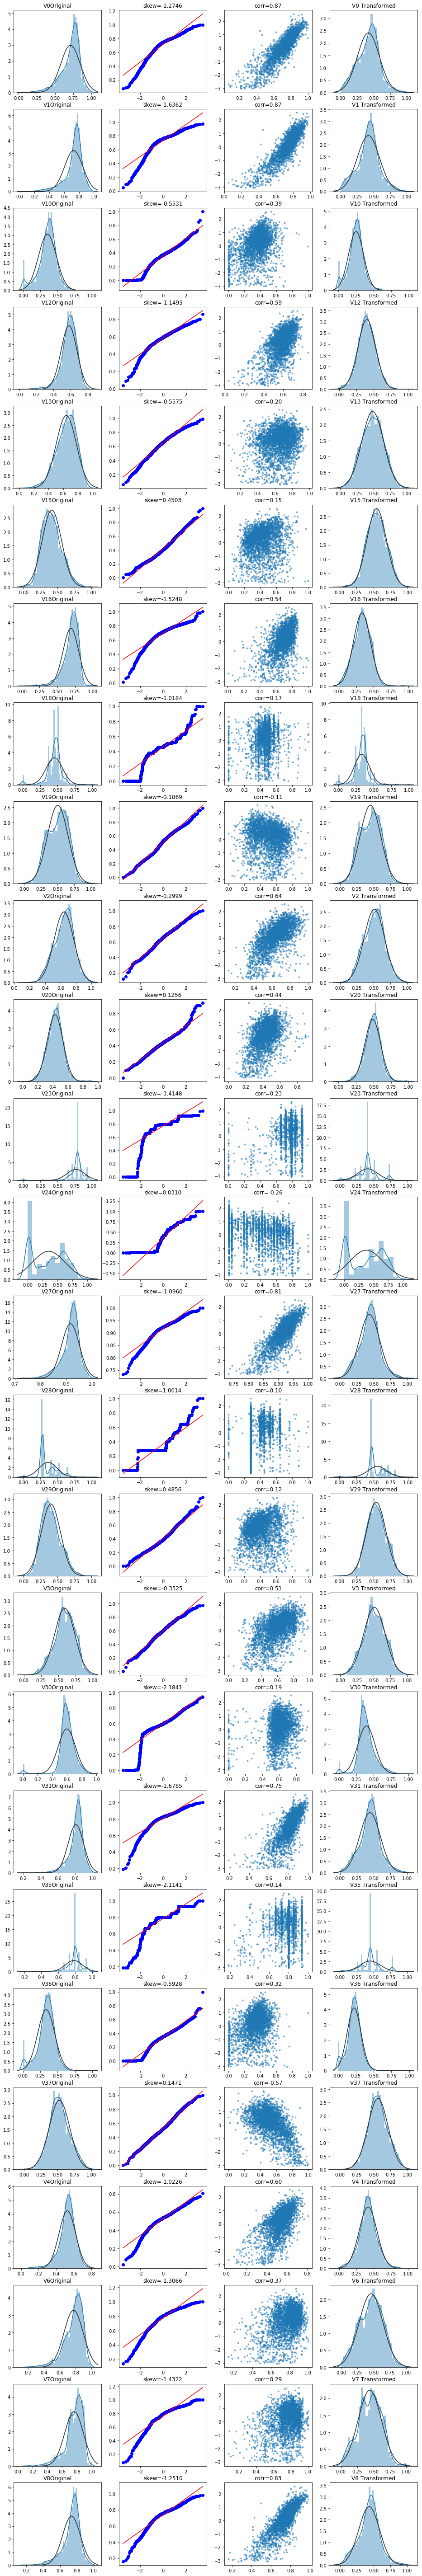

In [47]:
# check effect of Box-Cox transform on distributions of continues variables

fcols = 4
frows = len(cols_numeric) - 1
plt.figure(figsize=(4*fcols, 4*frows))
i = 0

for var in cols_numeric:
    if var != "target":
        dat = all_data[[var, 'target']].dropna()
        
        i += 1
        plt.subplot(frows, fcols, i)
        sns.distplot(dat[var], fit=stats.norm)
        plt.title(var + 'Original')
        plt.xlabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        _ = stats.probplot(dat[var], plot=plt)
        plt.title('skew='+'{:.4f}'.format(stats.skew(dat[var])))
        plt.xlabel('')
        plt.ylabel('')
        
        i += 1
        plt.subplot(frows, fcols, i)
        plt.plot(dat[var], dat['target'], '.', alpha=0.5)
        plt.title('corr='+'{:.2f}'.format(np.corrcoef(dat[var], dat['target'])[0][1]))
        
        i += 1
        plt.subplot(frows, fcols, i)
        trans_var, lambda_var = stats.boxcox(dat[var].dropna()+1)
        trans_var = scale_minmax(trans_var)
        sns.distplot(trans_var, fit=stats.norm)
        plt.title(var+' Transformed')
        plt.xlabel('')
        
plt.show()

In [56]:
all_data

V0        V1       V10       V12       V13       V15       V16  \
0     0.775775  0.723449  0.221743  0.570828  0.694786  0.402245  0.487950   
1     0.833742  0.778785  0.373887  0.564418  0.778544  0.402245  0.569779   
2     0.840231  0.796004  0.466415  0.570933  0.727300  0.372870  0.610021   
3     0.799856  0.769716  0.350013  0.577028  0.727600  0.379798  0.631207   
4     0.792790  0.805205  0.314675  0.599412  0.560084  0.383123  0.635467   
5     0.758327  0.803759  0.279606  0.609395  0.749026  0.417625  0.641968   
6     0.822350  0.776025  0.314001  0.623161  0.707072  0.417625  0.641968   
7     0.836049  0.790878  0.339493  0.607083  0.729248  0.436054  0.686582   
8     0.830858  0.833070  0.376180  0.619168  0.569224  0.442843  0.697904   
9     0.860995  0.860016  0.368087  0.650799  0.591399  0.446169  0.701155   
10    0.855083  0.867508  0.364985  0.692308  0.676656  0.543162  0.697343   
11    0.851766  0.868559  0.458727  0.733186  0.544951  0.556325  0.710907   
12    0.603028  0.595294  0.351902  0.534468  0.597543  0.622835  0.712140   
13    0.550108  0.544821  0.132317  0.499580  0.697633  0.688236  0.575160   
14    0.660418  0.688749  0.213110  0.614229  0.677705  0.688236  0.558794   
15    0.564672  0.582413  0.314810  0.552543  0.694037  0.676597  0.537944   
16    0.636049  0.657466  0.249798  0.616015  0.569224  0.627546  0.515301   
17    0.527181  0.519190  0.224845  0.516393  0.700779  0.627546  0.487950   
18    0.602163  0.680336  0.211762  0.598361  0.807911  0.502148  0.493218   
19    0.748234  0.776814  0.213650  0.633985  0.780641  0.494388  0.537160   
20    0.724585  0.771951  0.333693  0.626103  0.784237  0.409866  0.558570   
21    0.688248  0.733570  0.376180  0.599622  0.826341  0.367466  0.579868   
22    0.747368  0.784306  0.333153  0.586066  0.795625  0.367466  0.606098   
23    0.673540  0.675999  0.326275  0.574821  0.763560  0.342247  0.620222   
24    0.401730  0.371057  0.554087  0.404372  0.767156  0.358182  0.588275   
25    0.450180  0.434805  0.064203  0.492329  0.700030  0.405847  0.527183   
26    0.783273  0.753549  0.000944  0.600042  0.696284  0.484689  0.525165   
27    0.866619  0.874606  0.127327  0.676019  0.955948  0.484689  0.596234   
28    0.853641  0.876052  0.436741  0.731295  0.833683  0.598725  0.669207   
29    0.760779  0.784437  0.577691  0.651534  0.833983  0.591797  0.671674   
...        ...       ...       ...       ...       ...       ...       ...   
4783  0.746647  0.755258  0.128136  0.616120  0.720258  0.512124  0.563166   
4784  0.661283  0.651157  0.301322  0.593317  0.534912  0.527920  0.592759   
4785  0.537707  0.483964  0.347721  0.501471  0.515433  0.535680  0.528192   
4786  0.716943  0.696767  0.067845  0.595839  0.628858  0.539698  0.522251   
4787  0.646864  0.650105  0.294173  0.585225  0.612227  0.520299  0.554534   
4788  0.623648  0.636041  0.284866  0.592476  0.680551  0.520299  0.541755   
4789  0.675415  0.743691  0.317373  0.651219  0.658076  0.508660  0.562605   
4790  0.586590  0.609621  0.402212  0.608449  0.530866  0.497159  0.542092   
4791  0.669214  0.676393  0.160912  0.590269  0.497902  0.491478  0.517543   
4792  0.741168  0.791798  0.188832  0.636822  0.551543  0.483026  0.529537   
4793  0.832733  0.861856  0.322903  0.664460  0.565628  0.483026  0.570676   
4794  0.856092  0.892219  0.357027  0.645649  0.515883  0.486075  0.631992   
4795  0.874405  0.902208  0.358241  0.645965  0.485616  0.525010  0.641744   
4796  0.820908  0.836751  0.412193  0.659731  0.630057  0.544409  0.644771   
4797  0.814708  0.844243  0.379148  0.671290  0.501349  0.598725  0.649927   
4798  0.730497  0.751577  0.465066  0.638293  0.531016  0.598725  0.660352   
4799  0.695314  0.726209  0.325870  0.621900  0.654031  0.547319  0.598363   
4800  0.702379  0.750263  0.230105  0.624842  0.671112  0.499654  0.582558   
4801  0.641240  0.683754  0.394119  0.600357  0.454150  0.490093  0.590741   
4802  0.653208  0.708333  0.152684

In [57]:
# function to get training samples and test samples
def get_training_data():
    # extract training samples
    df_train = all_data[all_data["origin"] == "train"]
    df_train["label"] = df_train.target
    
    y = df_train.target
    X = df_train.drop(["origin", "target", "label"], axis=1)
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=100)
    return X_train, X_valid, y_train, y_valid

def get_test_data():
    df_test = all_data[all_data["origin"] == "test"].reset_index(drop=True)
    return df_test.drop(["origin", "target"], axis=1)

In [65]:
def rmse(y_true, y_pred):
    diff = y_true - y_pred
    sum_sq = sum(diff**2)
    return np.sqrt(sum_sq / len(y_true))

def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

In [83]:
model = LinearRegression()
X_train, X_valid, y_train, y_valid = get_training_data()
model.fit(X_train, y_train)

c:\program files (x86)\microsoft visual studio\shared\python36_64\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [84]:
mse(y_valid, model.predict(X_valid))

0.12699602387075523

In [85]:
mse(y_train, model.predict(X_train))

0.10995339975463463

In [67]:
X_test = get_test_data()
y_test = model.predict(X_test)

In [69]:
len(y_test)

1925

In [74]:
with open('./zhengqi_result.txt', mode="w") as fr_result:
    for i in y_test:
        fr_result.write(str(i) + "\n")